<a href="https://colab.research.google.com/github/shruthipavalavel/Multimedia-Processing-Sem-4-P/blob/main/multimediaquantisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()



Saving hellokitty.png to hellokitty.png


In [2]:
!pip install pillow numpy


In [3]:
from PIL import Image
import numpy as np
import os


In [4]:
def load_rgb_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    print("Loaded RGB image:", img_np.shape)
    return img_np


In [5]:
def greyscale_desaturation(img_np, image_path):
    grey_np = ((img_np.max(axis=2) + img_np.min(axis=2)) / 2).astype(np.uint8)
    grey_img = Image.fromarray(grey_np)

    base = os.path.splitext(os.path.basename(image_path))[0]
    outname = f"{base}_greyscale.png"
    grey_img.save(outname)
    print("Greyscale saved:", outname)
    return grey_np


In [6]:
def median_cut_quantize_rgb(img_np, num_colors=16):
    pixels = img_np.reshape(-1, 3)

    # start with one "box"
    boxes = [pixels]

    # split until we get desired number of colors
    while len(boxes) < num_colors:
        new_boxes = []
        for box in boxes:
            if len(box) == 0:
                continue
            # find channel with max spread
            ranges = box.max(axis=0) - box.min(axis=0)
            ch = np.argmax(ranges)
            # sort and split
            sorted_box = box[box[:, ch].argsort()]
            mid = len(sorted_box) // 2
            new_boxes.append(sorted_box[:mid])
            new_boxes.append(sorted_box[mid:])
        boxes = new_boxes

    # palette: mean of each box
    palette = np.array([box.mean(axis=0).astype(np.uint8) for box in boxes])

    # assign nearest color
    def nearest(c):
        d = np.sum((palette - c) ** 2, axis=1)
        return palette[np.argmin(d)]

    quantized = np.array([nearest(c) for c in pixels])
    quantized = quantized.reshape(img_np.shape)

    out = Image.fromarray(quantized)
    out.save("median_cut_color.png")
    print("Median Cut color saved: median_cut_color.png")
    return quantized


In [7]:
class OctreeNode:
    def __init__(self, level, max_depth):
        self.level = level
        self.max_depth = max_depth
        self.children = [None] * 8
        self.count = 0
        self.color_sum = np.zeros(3, dtype=np.int64)
        self.index = -1

    def is_leaf(self):
        return self.level == self.max_depth

def get_index(color, level):
    shift = 7 - level
    r = (color[0] >> shift) & 1
    g = (color[1] >> shift) & 1
    b = (color[2] >> shift) & 1
    return (r << 2) | (g << 1) | b

def insert_color(node, color):
    node.color_sum += color
    node.count += 1

def build_octree(img_np, max_depth=6):
    pixels = img_np.reshape(-1, 3)
    root = OctreeNode(0, max_depth)
    leaves = []

    for c in pixels:
        node = root
        for lvl in range(max_depth + 1):
            if node.is_leaf():
                insert_color(node, c)
                break
            idx = get_index(c, lvl)
            if node.children[idx] is None:
                node.children[idx] = OctreeNode(lvl + 1, max_depth)
                if node.children[idx].is_leaf():
                    leaves.append(node.children[idx])
            node = node.children[idx]
            insert_color(node, c)

    return root, leaves

def get_palette(leaves, num_colors):
    leaves = sorted(leaves, key=lambda n: n.count, reverse=True)
    chosen = leaves[:num_colors]
    for i, leaf in enumerate(chosen):
        leaf.index = i
    palette = [leaf.color_sum // leaf.count for leaf in chosen]
    return np.array(palette, dtype=np.uint8)

def octree_quantize_rgb(img_np, max_depth=6, num_colors=16):
    root, leaves = build_octree(img_np, max_depth)
    palette = get_palette(leaves, num_colors)

    pixels = img_np.reshape(-1, 3)
    out_pixels = []

    for c in pixels:
        d = np.sum((palette - c) ** 2, axis=1)
        out_pixels.append(palette[np.argmin(d)])

    out_img = np.array(out_pixels).reshape(img_np.shape)
    out = Image.fromarray(out_img)
    out.save("octree_color.png")
    print("Octree color saved: octree_color.png")
    return out_img


Loaded RGB image: (860, 860, 3)
Greyscale saved: hellokitty_greyscale.png
Median Cut color saved: median_cut_color.png
Octree color saved: octree_color.png


array([[[249, 236, 228],
        [246, 236, 228],
        [245, 234, 225],
        ...,
        [ 22,  29,  37],
        [ 22,  29,  37],
        [245, 234, 225]],

       [[249, 236, 228],
        [249, 236, 228],
        [246, 236, 228],
        ...,
        [ 22,  29,  37],
        [ 22,  29,  37],
        [245, 234, 225]],

       [[249, 236, 228],
        [ 26,  29,  34],
        [249, 236, 228],
        ...,
        [ 22,  29,  37],
        [ 26,  34,  44],
        [245, 234, 225]],

       ...,

       [[248, 244, 229],
        [245, 234, 225],
        [245, 234, 225],
        ...,
        [ 22,  30,  40],
        [245, 234, 225],
        [249, 236, 228]],

       [[248, 244, 229],
        [245, 234, 225],
        [245, 234, 225],
        ...,
        [ 22,  30,  40],
        [245, 234, 225],
        [249, 236, 228]],

       [[248, 244, 229],
        [245, 234, 225],
        [245, 234, 225],
        ...,
        [ 22,  30,  40],
        [245, 234, 225],
        [249, 236, 228]]], dtype=uint8)
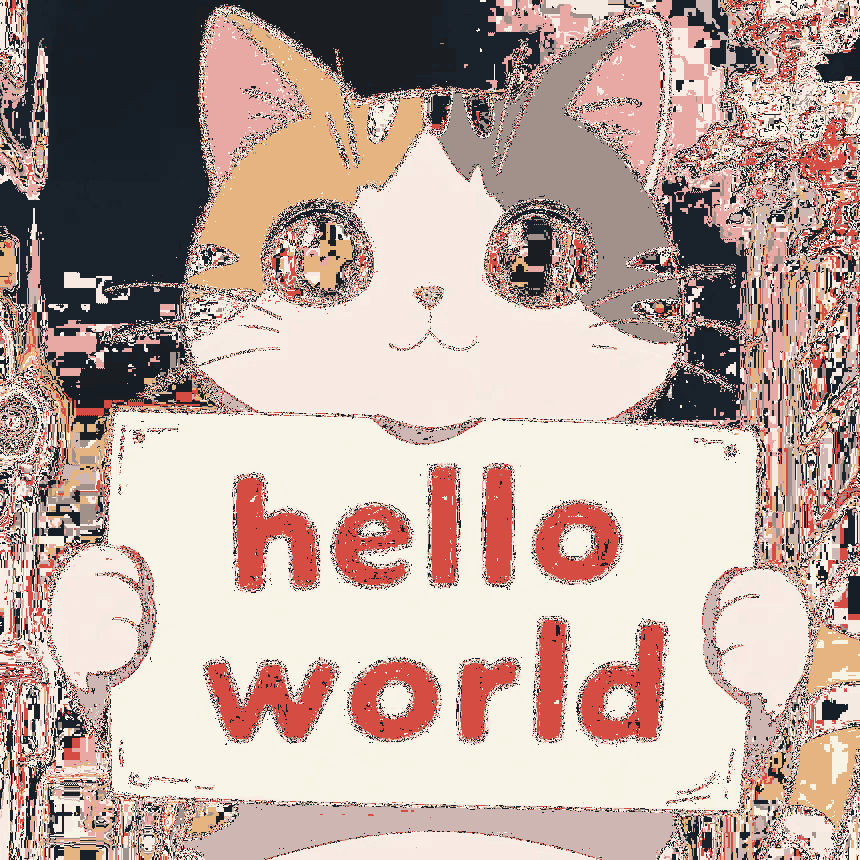

In [8]:
image_path = "/content/hellokitty.png"   # ← replace with uploaded file path

rgb_np = load_rgb_image(image_path)

# 1. Greyscale
greyscale_desaturation(rgb_np, image_path)

# 2. Median Cut (COLOR)
median_cut_quantize_rgb(rgb_np, num_colors=16)

# 3. Octree (COLOR)
octree_quantize_rgb(rgb_np, max_depth=6, num_colors=16)
